In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import json
import pickle

from fuzzywuzzy import fuzz
from fuzzywuzzy import process

import seaborn as sns
sns.set()

# Importing three shelter datasets #

In [2]:
df1 = pd.read_csv('Austin_Animal_Center_Outcomes.csv')
df2 = pd.read_csv('Animal_Shelter_Intake_and_Outcome.csv')
df3 = pd.read_csv('Animal_IO_Data_0.csv')

In [3]:
df1.columns

Index(['Animal ID', 'Name', 'DateTime', 'MonthYear', 'Date of Birth',
       'Outcome Type', 'Outcome Subtype', 'Animal Type', 'Sex upon Outcome',
       'Age upon Outcome', 'Breed', 'Color'],
      dtype='object')

In [4]:
df2.columns

Index(['Name', 'Type', 'Breed', 'Color', 'Sex', 'Size', 'Date Of Birth',
       'Impound Number', 'Kennel Number', 'Animal ID', 'Intake Date',
       'Outcome Date', 'Days in Shelter', 'Intake Type', 'Intake Subtype',
       'Outcome Type', 'Outcome Subtype', 'Intake Condition',
       'Outcome Condition', 'Intake Jurisdiction', 'Outcome Jurisdiction',
       'Outcome Zip Code', 'Location', 'Count'],
      dtype='object')

In [5]:
df3.columns

Index(['AnimalID', 'AnimalType', 'IntakeDate', 'IntakeType', 'IntakeSubtype',
       'PrimaryColor', 'PrimaryBreed', 'SecondaryBreed', 'Gender',
       'SecondaryColor', 'DOB', 'IntakeReason', 'IntakeInternalStatus',
       'IntakeAsilomarStatus', 'ReproductiveStatusAtIntake', 'OutcomeDate',
       'OutcomeType', 'OutcomeSubtype', 'OutcomeReason',
       'OutcomeInternalStatus', 'OutcomeAsilomarStatus',
       'ReproductiveStatusAtOutcome'],
      dtype='object')

# Cleaning up the datasets and engineering features #

In [6]:
# Function to drop all animals other than dogs
def drop_other(df):
    df['Animal Type'] = df['Animal Type'].str.title()
    df = df[df['Animal Type'] == 'Dog']
    df = df.drop('Animal Type', axis=1)
    return df

In [7]:
# Function to clean up dates and at 'Age at Outcome' feature
def stand_dates(df):
    df['Age at Outcome'] = (pd.to_datetime(df['Outcome Date'],
                                           infer_datetime_format=True) - pd.to_datetime(df['Date of Birth'],
                                           infer_datetime_format=True))
    df['Age at Outcome'] = df['Age at Outcome'].astype(str).apply(lambda x: x[:-24])
    return df

In [8]:
# Function to clean colors and add secondary color
def colors(df):
    df['Color'] = df['Color'].str.replace('/', ' ')
    df['Color'] = df['Color'].fillna('Unknown')
    df['Color'] = df['Color'].str.split(' ')
    df['Color'] = df['Color'].map(lambda x: x[:2])
    df['Secondary Color'] = np.where(df['Color'].str.len() == 2, df['Color'].map(lambda x: x[-1]), np.nan)
    df['Primary Color'] = df['Color'].map(lambda x: x[0])
    df = df.drop('Color', axis=1)
    return df

In [9]:
# Function to clean sex and add sterilized feature
def sex_sterilized(df):
    df['Sex'] = df['Sex'].fillna('Unknown')
    df['Sex'] = df['Sex'].str.split(' ')

    if 'Sterilized' not in df.columns:
        df['Sterilized'] = ''
    df['Sterilized'] = (np.where(df['Sex'].str.len() == 2,
                        df['Sex'].map(lambda x: x[0]),
                        df['Sterilized']))

    df['Sex'] = (np.where(df['Sex'].str.len() == 2,
                 df['Sex'].map(lambda x: x[-1]),
                 df['Sex']))

    df['Sex'] = df['Sex'].str.join('')
    df['Sterilized'] = df['Sterilized'].str.title()

    df['Sterilized'] = (df['Sterilized'].replace('Neutered', 'Yes')
                                        .replace('Spayed', 'Yes')
                                        .replace('Intact', 'No')
                                        .replace('Fertile', 'No')
                                        .replace('Altered', 'Yes'))
    return df

In [10]:
df1 = df1.rename({'Sex upon Outcome': 'Sex', 'DateTime': 'Outcome Date', 'Age upon Outcome': 'Age at Outcome'},
                 axis=1)

In [11]:
# Keeping just the dogs; cleaning colors
df1 = drop_other(df1)
df1 = colors(df1)
df1 = sex_sterilized(df1)

In [12]:
# Convert 'Age at Outcome' to days
df1 = df1.dropna(subset=['Age at Outcome'])
df1['Age at Outcome'] = df1['Age at Outcome'].str.replace('s', '')
df1['Age at Outcome'] = df1['Age at Outcome'].str.replace(' day', '')
df1['Age at Outcome'] = df1['Age at Outcome'].str.replace(' month', ',30')
df1['Age at Outcome'] = df1['Age at Outcome'].str.replace(' week', ',52')
df1['Age at Outcome'] = df1['Age at Outcome'].str.replace(' year', ',365')
df1['Age at Outcome'] = df1['Age at Outcome'].str.split(',').apply(lambda x: [int(y) for y in x])
df1['Age at Outcome'] = df1['Age at Outcome'].map(np.prod)

In [13]:
# Converting features to datetime objects to engineer features; adding empty features for engineering
df1['Days in Shelter'] = np.nan
df1['Secondary Breed'] = ''

In [14]:
# Dropping unneeded features
df1['Outcome Date'] = df1['Outcome Date'].astype(str).apply(lambda x: x[:-12])
df1 = df1.drop(['Animal ID', 'MonthYear', 'Name', 'Outcome Subtype'], axis=1)
df1 = df1.sort_index(axis=1)

In [15]:
# Subsetting only needed features
df2 = df2.loc[:, ['Type', 'Breed', 'Color', 'Sex', 'Date Of Birth', 'Outcome Date', 'Days in Shelter',
                  'Outcome Type']]

In [16]:
# Renaming features
df2 = df2.rename({'Type': 'Animal Type', 'Outcome Date': 'Outcome Date', 'Date Of Birth': 'Date of Birth'},
                 axis=1)

In [17]:
df2 = drop_other(df2)
df2 = stand_dates(df2)
df2 = colors(df2)

In [18]:
# Adding 'Secondary Breed' feature
df2['Secondary Breed'] = ''
df2 = df2.sort_index(axis=1)

In [19]:
# Standardizing 'Sterilized' and 'Sex' features
df2['Sterilized'] = np.where(df2['Sex'] == 'Neutered', 'Yes', '')
df2['Sterilized'] = np.where(df2['Sex'] == 'Spayed', 'Yes', df2['Sterilized'])
df2['Sex'] = (df2['Sex'].replace('Neutered', 'Male')
                        .replace('Spayed', 'Female'))

In [21]:
# Subsetting only needed features
df3 = df3.loc[:, ['AnimalType', 'IntakeDate', 'PrimaryColor', 'PrimaryBreed', 'SecondaryBreed', 'Gender',
                  'SecondaryColor', 'DOB', 'ReproductiveStatusAtOutcome', 'OutcomeDate', 'OutcomeType']]

In [22]:
# Renaming features
df3 = df3.rename({'AnimalType': 'Animal Type', 'Gender': 'Sex', 'OutcomeDate': 'Outcome Date',
                  'PrimaryBreed': 'Breed', 'OutcomeType': 'Outcome Type', 'DOB': 'Date of Birth',
                  'SecondaryBreed': 'Secondary Breed', 'PrimaryColor': 'Color',
                  'ReproductiveStatusAtOutcome': 'Sterilized'}, axis=1)

In [23]:
df3 = drop_other(df3)
df3 = stand_dates(df3)
df3 = colors(df3)
df3 = sex_sterilized(df3)

In [24]:
# Cleaning colors
df3['SecondaryColor'] = df3['SecondaryColor'].fillna('Unknown')
df3['SecondaryColor'] = df3['SecondaryColor'].str.split(' ').map(lambda x: x[0])
df3['Secondary Color'] = df3['Secondary Color'].fillna('Unknown')
df3['Secondary Color'] = np.where(df3['Secondary Color'] == 'Unknown', df3['SecondaryColor'], np.nan)
df3['Secondary Color'] = df3['Secondary Color'].replace('Unknown', np.nan)
df3 = df3.drop('SecondaryColor', axis=1)

In [25]:
# Converting features to datetime objects to engineer features; adding empty features for engineering
df3['Outcome Date'] = df3['Outcome Date'].astype(str).apply(lambda x: x[:-9])
df3['Days in Shelter'] = pd.to_datetime(df3['Outcome Date'],
                                        infer_datetime_format=True) - pd.to_datetime(df3['IntakeDate'])
df3['Days in Shelter'] = df3['Days in Shelter'].apply(lambda x: x.days)

In [26]:
# Data cleanup
df3['Age at Outcome'] = df3['Age at Outcome'].replace('', np.nan)
df3['Age at Outcome'] = pd.to_numeric(df3['Age at Outcome'])

In [27]:
# Changing negative days in shelter to positive
df3['Days in Shelter'] = np.where(df3['Days in Shelter'] < 0, -df3['Days in Shelter'],
                                  df3['Days in Shelter'])

In [28]:
# Changing reproductive status values
df3['Sterilized'] = df3['Sterilized'].replace('ALTERED', 'Yes')
df3['Sterilized'] = df3['Sterilized'].replace('FERTILE', 'No')

In [29]:
# Dropping uneeded features
df3 = df3.drop(['IntakeDate', 'IntakeDate'], axis=1)
df3 = df3.sort_index(axis=1)

In [31]:
# Combining all datasets
df_dogs = pd.concat([df1, df2, df3], axis=0)

In [32]:
# Changing negative days in 'Age at Outcome' to positive and changed from days to years
df_dogs['Age at Outcome'] = pd.to_numeric(df_dogs['Age at Outcome'])
df_dogs['Age at Outcome'] = np.where(df_dogs['Age at Outcome'] < 0, -df_dogs['Age at Outcome'],
                                     df_dogs['Age at Outcome'])
df_dogs['Age at Outcome'] = df_dogs['Age at Outcome'].divide(365).round(2)

In [33]:
# Converting to datetime
df_dogs['Outcome Date'] = pd.to_datetime(df_dogs['Outcome Date'], infer_datetime_format=True)

In [34]:
# Data cleaning
df_dogs['Sex'] = df_dogs['Sex'].str.title()
df_dogs['Sex'] = df_dogs['Sex'].replace('Litter', np.nan)
df_dogs['Sterilized'] = df_dogs['Sterilized'].str.title()
df_dogs['Sterilized'] = df_dogs['Sterilized'].replace('', np.nan)
df_dogs['Primary Color'] = df_dogs['Primary Color'].str.title()
df_dogs['Secondary Color'] = df_dogs['Secondary Color'].str.title()
df_dogs['Outcome Type'] = df_dogs['Outcome Type'].str.title()
df_dogs['Outcome Type'] = df_dogs['Outcome Type'].replace('Release', 'Released')
df_dogs['Outcome Type'] = df_dogs['Outcome Type'].replace('Rto-Adopt', 'Returned To Owner')
df_dogs['Outcome Type'] = df_dogs['Outcome Type'].replace('Return To Owner', 'Returned To Owner')
df_dogs['Outcome Type'] = df_dogs['Outcome Type'].replace('Rtf', 'Foster')
df_dogs['Outcome Type'] = df_dogs['Outcome Type'].replace('Escaped/Stolen', 'Missing')
df_dogs['Outcome Type'] = df_dogs['Outcome Type'].replace('Rto', 'Returned To Owner')
df_dogs['Outcome Type'] = df_dogs['Outcome Type'].replace('Adoption', 'Adopted')
df_dogs['Outcome Type'] = df_dogs['Outcome Type'].replace('Euth', 'Euthanized')
df_dogs['Outcome Type'] = df_dogs['Outcome Type'].replace('Euthanasia', 'Euthanized')
df_dogs['Outcome Type'] = df_dogs['Outcome Type'].replace('Euthanize', 'Euthanized')
df_dogs = df_dogs.reset_index(drop=True)

In [35]:
# Data cleanup; creating bloodline feature
df_dogs['Day'] = df_dogs['Outcome Date'].apply(lambda x: x.dayofyear)
df_dogs['Breed'] = df_dogs['Breed'].str.split('/')
df_dogs['Breed'] = df_dogs['Breed'].apply(lambda x: x[0])
df_dogs['Breed'] = df_dogs['Breed'].str.title()
df_dogs['Breed'] = df_dogs['Breed'].str.split('-').str[0].str.strip()
df_dogs['Secondary Breed'] = df_dogs['Secondary Breed'].fillna('Unknown')
df_dogs['Secondary Breed'] = df_dogs['Secondary Breed'].replace('', 'Unknown')
df_dogs['Pure'] = 'Yes'
df_dogs['Pure'] = (np.where((df_dogs['Breed'].str.contains('Mix')) | (df_dogs['Secondary Breed'] != 'Unknown'),
                            'No',
                            'Yes'))

df_dogs = df_dogs.drop('Secondary Breed', axis=1)
df_dogs = df_dogs.drop('Date of Birth', axis=1)

In [36]:
# Creating season feature
bins = [0, 79, 169, 262, 356, 365]
labels = ['Wint', 'Spring', 'Summer', 'Fall', 'Winter']
df_dogs['Season'] = pd.cut(df_dogs['Day'], bins=bins, labels=labels)
df_dogs['Season'] = df_dogs['Season'].replace('Wint', 'Winter')
df_dogs = df_dogs.drop('Day', axis=1)
df_dogs = df_dogs.reset_index(drop=True)

In [37]:
# Importing a dictionary of all AKC breeds and their corresponding group
group_dict = pickle.load(open('group_dict.pkl', 'rb'))

In [38]:
# Fuzzywuzzy string matching function to change all dog names to AKC dog names if score is below a threshold
def clean_breeds(dog):
    if dog in list(group_dict):
        return dog
    new_breed, score = process.extractOne(dog, list(group_dict))
    if score < 85:
        return dog
    else:
        return new_breed

In [39]:
# Fuzzywuzzy needs a little help
df_dogs['Breed'] = df_dogs['Breed'].str.replace(' Mix$', '')
df_dogs['Breed'] = df_dogs['Breed'].str.replace('Am ', 'American ')
df_dogs['Breed'] = df_dogs['Breed'].str.replace('Amer ', 'American ')
df_dogs['Breed'] = df_dogs['Breed'].str.replace('Ter$', 'Terrier')
df_dogs['Breed'] = df_dogs['Breed'].str.replace('Terr$', 'Terrier')
df_dogs['Breed'] = df_dogs['Breed'].str.replace('Aust ', 'Australian ')
df_dogs['Breed'] = df_dogs['Breed'].str.replace('Eng ', 'English ')
df_dogs['Breed'] = df_dogs['Breed'].str.replace(' \(Redtick Coonhound\)', '')
df_dogs['Breed'] = df_dogs['Breed'].str.replace('Norw ', 'Norwegian ')
df_dogs['Breed'] = df_dogs['Breed'].str.replace('Scot ', 'Scottish ')

rep_list = ['Labrador Retr', 'Labrador Retriever', 'Germ Sh Point', 'German Shorthaired Pointer',
            'Welsh Corgi Pem', 'Pembroke Welsh Corgi', 'Golden Retr', 'Golden Retriever',
            'Welsh Corgi Car', 'Cardigan Welsh Corgi', 'Schnauzer Min', 'Miniature Schnauzer',
            'Germ Wh Point', 'Pointer']

rep_dict = dict(zip(rep_list[::2], rep_list[1::2]))
df_dogs['Breed'] = df_dogs['Breed'].map(rep_dict).fillna(df_dogs['Breed'])

In [41]:
# Standardizing all breeds to AKC
df_dogs['Breed'] = df_dogs['Breed'].map(clean_breeds)

In [47]:
# Adding 'Percent Breed Per Outcome Per Year' feature
df_dogs['Outcome Year'] = df_dogs['Outcome Date'].dt.year
df_dogs = df_dogs.drop('Outcome Date', axis=1)
df_dogs = df_dogs[df_dogs['Outcome Year'] > 2004]
df_breed_out = (df_dogs.groupby(['Outcome Year', 'Outcome Type', 'Breed']).size()
                                                                          .rename('Count')
                                                                          .reset_index())
df_breed_count = (df_dogs.groupby(['Outcome Year', 'Breed']).size()
                                                            .rename('Count')
                                                            .reset_index())
df_breed_merged = df_breed_out.merge(df_breed_count,
                                     on=['Outcome Year', 'Breed'],
                                     how='left',
                                     suffixes=(' Outcome', ' Total'))

df_breed_merged['Percent Breed Outcome Year'] = df_breed_merged['Count Outcome'].divide(df_breed_merged['Count Total'])
df_breed_merged = df_breed_merged.drop(['Count Outcome', 'Count Total'], axis=1)
df_breed_merged['Outcome Year'] += 1
df_dogs = df_dogs.merge(df_breed_merged, on=['Outcome Year', 'Outcome Type', 'Breed'], how='left')
df_dogs = df_dogs.drop('Outcome Year', axis=1)

In [48]:
# Adding 'Group' feature
df_dogs['Group'] = df_dogs['Breed'].map(group_dict)
df_dogs['Group'] = df_dogs['Group'].str.replace(' & Toy', '')
df_dogs['Group'] = df_dogs['Group'].str.replace('Terrier ', 'Terrier')

In [49]:
# Importing dog rank, lifespan and weight
dog_all = pickle.load(open('dog_all.pkl', 'rb'))
df_dogs = df_dogs.merge(dog_all, on='Breed', how='left')

In [50]:
# Standardizing 'Puppy' feature
df_dogs['Size'] = df_dogs['Size'].fillna('Unknown')
df_dogs['Puppy'] = ''
df_dogs['Puppy'] = (np.where((df_dogs['Size'] == 'XSmall') & (df_dogs['Age at Outcome'] > 8 / 12),
                             'Yes',
                             df_dogs['Puppy']))

df_dogs['Puppy'] = (np.where((df_dogs['Size'] == 'Small') & (df_dogs['Age at Outcome'] > 10 / 12),
                             'Yes',
                             df_dogs['Puppy']))

df_dogs['Puppy'] = (np.where((df_dogs['Size'] == 'Medium') & (df_dogs['Age at Outcome'] > 1),
                             'Yes',
                             df_dogs['Puppy']))

df_dogs['Puppy'] = (np.where((df_dogs['Size'] == 'Large') & (df_dogs['Age at Outcome'] > 15 / 12),
                             'Yes',
                             df_dogs['Puppy']))

df_dogs['Puppy'] = (np.where((df_dogs['Size'] == 'XLarge') & (df_dogs['Age at Outcome'] > 18 / 12),
                             'Yes',
                             df_dogs['Puppy']))

df_dogs['Puppy'] = (np.where((df_dogs['Size'] == 'XSmall') & (df_dogs['Age at Outcome'] <= 8 / 12),
                             'No',
                             df_dogs['Puppy']))

df_dogs['Puppy'] = (np.where((df_dogs['Size'] == 'Small') & (df_dogs['Age at Outcome'] <= 10 / 12),
                             'No',
                             df_dogs['Puppy']))

df_dogs['Puppy'] = (np.where((df_dogs['Size'] == 'Medium') & (df_dogs['Age at Outcome'] <= 1),
                             'No',
                             df_dogs['Puppy']))

df_dogs['Puppy'] = (np.where((df_dogs['Size'] == 'Large') & (df_dogs['Age at Outcome'] <= 15 / 12),
                             'No',
                             df_dogs['Puppy']))

df_dogs['Puppy'] = (np.where((df_dogs['Size'] == 'XLarge') & (df_dogs['Age at Outcome'] <= 18 / 12),
                             'No',
                             df_dogs['Puppy']))

df_dogs['Puppy'] = np.where(df_dogs['Age at Outcome'].isna(), np.nan, df_dogs['Puppy'])

In [51]:
# Cleaning color features
df_dogs['Primary Color'] = df_dogs['Primary Color'].replace('Bl', 'Black')
df_dogs['Primary Color'] = df_dogs['Primary Color'].replace('Blk', 'Black')
df_dogs['Primary Color'] = df_dogs['Primary Color'].replace('Br', 'Brown')
df_dogs['Primary Color'] = df_dogs['Primary Color'].replace('Brn', 'Brown')
df_dogs['Primary Color'] = df_dogs['Primary Color'].replace('Y', 'Yellow')
df_dogs['Secondary Color'] = df_dogs['Secondary Color'].replace('Bl', 'Black')
df_dogs['Secondary Color'] = df_dogs['Secondary Color'].replace('Br', 'Brown')
df_dogs['Secondary Color'] = df_dogs['Secondary Color'].replace('Brn', 'Brown')

In [52]:
# Adding Mean Age at Outcome per Breed feature
df_mean_breed_age_outcome = df_dogs.groupby(['Breed'])['Age at Outcome'].mean().reset_index()
df_dogs = df_dogs.merge(df_mean_breed_age_outcome, how='outer', on='Breed', suffixes=('', ' Breed'))
df_dogs = df_dogs.rename({'Age at Outcome Breed': 'Mean Age at Outcome Breed'}, axis=1)

# Preparing Data for Modeling #

In [53]:
# Reducing target outcome to three classes
df_dogs = (df_dogs[(df_dogs['Outcome Type'] == 'Adopted') |
                   (df_dogs['Outcome Type'] == 'Euthanized') |
                   (df_dogs['Outcome Type'] == 'Returned To Owner')])

In [54]:
# Dropping unreasonably old dogs
df_dogs = df_dogs[(df_dogs['Age at Outcome'] < 27) | (df_dogs['Age at Outcome'].isnull())].reset_index(drop=True)

In [55]:
# Looking at class imbalance
df_dogs['Outcome Type'].value_counts()

Adopted              41420
Euthanized           32754
Returned To Owner    32412
Name: Outcome Type, dtype: int64

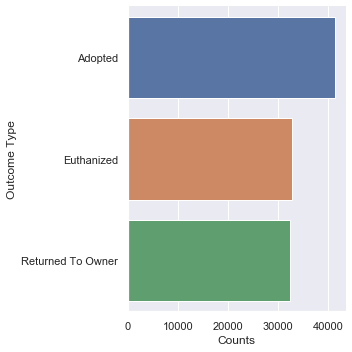

In [56]:
df_plot = (df_dogs['Outcome Type'].value_counts()
                                  .reset_index()
                                  .rename({'Outcome Type': 'Counts', 'index': 'Outcome Type'}, axis=1))
sns.catplot(y='Outcome Type', x='Counts', data=df_plot, kind='bar')

In [58]:
# Dropping engineered features to use in a baseline model
df_pre_features = df_dogs.copy()
df_pre_features['Color'] = np.where(df_pre_features['Secondary Color'].isna(),
                                    df_pre_features['Primary Color'],
                                    df_pre_features['Primary Color'] + ' ' + df_pre_features['Secondary Color'])

df_pre_features = df_pre_features.drop(['Primary Color', 'Secondary Color',
                                        'Pure', 'Season', 'Percent Breed Outcome Year',
                                        'Group', 'Puppy', 'Mean Age at Outcome Breed',
                                        'Days in Shelter', 'Rank_2017', 'Rank_2016',
                                        'Rank_2015', 'Rank_2014', 'Rank_2013', 'Median Life Expectancy',
                                        'Size', 'Mean Weight Breed'], axis=1)

df_pre_features['Breed'] = df_pre_features['Breed'].astype('category')
df_pre_features['Sterilized'] = df_pre_features['Sterilized'].astype('category')
df_pre_features['Sex'] = df_pre_features['Sex'].astype('category')
df_pre_features['Color'] = df_pre_features['Color'].astype('category')

In [59]:
# Categorizing features for modeling
df_dogs['Breed'] = df_dogs['Breed'].astype('category')
df_dogs['Primary Color'] = df_dogs['Primary Color'].astype('category')
df_dogs['Secondary Color'] = df_dogs['Secondary Color'].astype('category')
df_dogs['Sterilized'] = df_dogs['Sterilized'].astype('category')
df_dogs['Pure'] = df_dogs['Pure'].astype('category')
df_dogs['Season'] = df_dogs['Season'].astype('category')
df_dogs['Group'] = df_dogs['Group'].astype('category')
df_dogs['Size'] = df_dogs['Size'].astype('category')
df_dogs['Puppy'] = df_dogs['Puppy'].astype('category')
df_dogs['Sex'] = df_dogs['Sex'].astype('category')